## Proyecto Final 
## Materia: BIG DATA
###  Elaborado por: Francisco D. Tudisco 8-910-131


### Justificacion del uso de BIG DATA

El dataset de reseñas de vinos contiene más de 250,000 registros que describen vinos de distintos países, variedades, precios, puntuaciones y comentarios realizados por catadores expertos. Este volumen de datos representa una oportunidad ideal para aplicar tecnologías y principios de Big Data, por la complejidad y riqueza de la información que contiene. Implementar soluciones de Big Data permite extraer insights significativos, escalar el análisis y tomar decisiones más inteligentes y basadas en datos.

El uso de herramientas Big Data como Apache Spark, o bases de datos distribuidas como Cassandra permite:
- Procesar el dataset de forma distribuida.
- Aplicar modelos de machine learning a gran escala.
- Manejar pipelines de datos complejos y escalables.



### Descripcion del Problema

El sector vitivinícola se enfrenta a un mercado altamente competitivo, donde miles de vinos compiten por la atención de consumidores exigentes que valoran la calidad, el precio y la experiencia de consumo. En este contexto, entender qué factores influyen en la percepción de calidad del vino se vuelve fundamental para productores, distribuidores, y plataformas de venta.
Cada registro incluye atributos como: Precio del vino, Descripción textual del vino, País y región de origen.

### Librerias Requeridas

In [1]:
# Importacion de Librerias requeridas 
from pyspark.sql import SparkSession
import pyspark 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
import sys
import os
from pyspark.sql.functions import *
from pyspark.sql.functions import regexp_extract
from pyspark.sql.functions import col
from pyspark.ml.stat import Correlation

from pyspark.sql.types import StructType, StructField, StringType, FloatType

print(f'Version de Apache Spark: {pyspark.__version__}')
import warnings
warnings.filterwarnings("ignore") 

Version de Apache Spark: 4.0.0


### Crea una sesion de Apache Spark para realizar Analitica

In [2]:

spark = SparkSession.builder \
    .appName("TestApp") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/28 23:39:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### LECTURA TABLA DESDE CASSANDRA: RESEÑA DE VINOS

In [3]:

from cassandra.auth import PlainTextAuthProvider
import pandas as pd

from pyspark.sql.functions import col
from pyspark.ml.stat import Correlation


from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
from cassandra.cluster import Cluster


# Start Spark session
spark = SparkSession.builder.appName("ReadFromCassandra").getOrCreate()

# Connect to Cassandra
cluster = Cluster(['127.0.0.1'])
session = cluster.connect('projectofinal')

try:
    # Execute SELECT query
    rows = session.execute('SELECT * FROM wines_reviews')
    data = []
    for row in rows:
        d = row._asdict()
        # Convert UUID to string (or None)
        d['id'] = str(d['id']) if d['id'] is not None else None
        data.append(d)

    # Define schema explicitly:
    schema = StructType([
        StructField("id", StringType(), True),   # UUID as string
        StructField("country", StringType(), True),
        StructField("description", StringType(), True),
        StructField("designation", StringType(), True),
        StructField("points", DoubleType(), True),
        StructField("prices", DoubleType(), True),
        StructField("province", StringType(), True),
        StructField("region_1", StringType(), True),
        StructField("region_2", StringType(), True),
        StructField("variety", StringType(), True),
        StructField("winery", StringType(), True),
    ])

    df_stream = spark.createDataFrame(data, schema=schema)

    # Drop the 'id' column if you want:
    df_stream = df_stream.drop('id')

    # ✅ Show sample rows
    print("✅ Query completed. Sample output:")
    df_stream.show(10)

    #  (rows and columns)

    print(f"✅ Show shape: {df_stream.count()}, Columns: {len(df_stream.columns)}")


except Exception as e:
    print("❌ Error during query:", e)

finally:
    cluster.shutdown()
    print("✅ Cassandra connection closed.")


25/07/28 23:39:46 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


✅ Query completed. Sample output:


25/07/28 23:39:56 WARN TaskSetManager: Stage 0 contains a task of very large size (49446 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

+--------+--------------------+--------------------+------+------+-----------------+--------------------+-----------------+--------------------+------------------+
| country|         description|         designation|points|prices|         province|            region_1|         region_2|             variety|            winery|
+--------+--------------------+--------------------+------+------+-----------------+--------------------+-----------------+--------------------+------------------+
|      US|This wine is beau...| Nicholas Estate Dry|  91.0|  22.0|           Oregon|  Chehalem Mountains|Willamette Valley|            Riesling|         Anam Cara|
|   Chile|Crisp, spicy, gra...|Clava Coastal Res...|  87.0|  12.0|Casablanca Valley|                NULL|             NULL|     Sauvignon Blanc|           Quintay|
|  France|This is so fresh ...|                Brut|  90.0|  25.0|     Loire Valley|    Crémant de Loire|             NULL|     Sparkling Blend|       Monmousseau|
|      US|Whiffs

25/07/28 23:39:57 WARN TaskSetManager: Stage 1 contains a task of very large size (49446 KiB). The maximum recommended task size is 1000 KiB.
[Stage 1:>                                                          (0 + 2) / 2]

✅ Show shape: 258210, Columns: 10
✅ Cassandra connection closed.


### Transformacion de SPARK.DATAFRAME TO PANDAS.DATAFRAME

In [4]:

df_stream.limit(5).toPandas().style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])


25/07/28 23:39:59 WARN TaskSetManager: Stage 4 contains a task of very large size (49446 KiB). The maximum recommended task size is 1000 KiB.


,country,description,designation,points,prices,province,region_1,region_2,variety,winery
0,US,"This wine is beautifully rendered, with pear and melon backed by hints of citrus. The length, persistance, balance and tension are superb, and the mouth-puckering finish will have you reaching for another glass.",Nicholas Estate Dry,91.000000,22.000000,Oregon,Chehalem Mountains,Willamette Valley,Riesling,Anam Cara
1,Chile,"Crisp, spicy, grassy, citrus aromas are all good. This is acidic and cleansing; zesty flavors of orange and pineapple finish nervy, pithy and a touch bitter. For patio-ready SB, this is ideal.",Clava Coastal Reserve,87.000000,12.000000,Casablanca Valley,None,None,Sauvignon Blanc,Quintay
2,France,"This is so fresh and crisp with an attractive mineral character that points up the crisp apple flavors. There is a fine touch of citrus acidity as well to enhance the freshness of the wine. It is delicious, bright and refreshingly light.",Brut,90.000000,25.000000,Loire Valley,Crémant de Loire,None,Sparkling Blend,Monmousseau
3,US,"Whiffs of sweet baking spice, cedar and tobacco entice from nose to finish on this unabashedly fruity and oaky, but enjoyable Cab. Juicy vanilla-cherry cola notes permeate the rich palate, cut by a razor's edge of acidity on the finish.",None,87.000000,26.000000,New York,Finger Lakes,Finger Lakes,Cabernet Sauvignon,Ventosa
4,France,Aromas of melon and toasted marshmallow precede a palate that is full bodied yet remarkably crisp. Flavors of melon and orange rind dominate through the slightly warm finish.,La Bachole,89.000000,120.000000,Rhône Valley,Hermitage,None,Rhône-style White Blend,Les Vins de Vienne


### Analitica General del Dataset

In [5]:
df_stream.dtypes

[('country', 'string'),
 ('description', 'string'),
 ('designation', 'string'),
 ('points', 'double'),
 ('prices', 'double'),
 ('province', 'string'),
 ('region_1', 'string'),
 ('region_2', 'string'),
 ('variety', 'string'),
 ('winery', 'string')]

In [6]:
df_stream.printSchema()

root
 |-- country: string (nullable = true)
 |-- description: string (nullable = true)
 |-- designation: string (nullable = true)
 |-- points: double (nullable = true)
 |-- prices: double (nullable = true)
 |-- province: string (nullable = true)
 |-- region_1: string (nullable = true)
 |-- region_2: string (nullable = true)
 |-- variety: string (nullable = true)
 |-- winery: string (nullable = true)



In [7]:

df_stream = df_stream.filter((df_stream["Prices"].isNotNull()) & (df_stream["Points"].isNotNull()))
print('Shape of the dataset (NOT NULL):', (df_stream.count(), len(df_stream.columns)))


25/07/28 23:39:59 WARN TaskSetManager: Stage 5 contains a task of very large size (49446 KiB). The maximum recommended task size is 1000 KiB.
[Stage 5:>                                                          (0 + 2) / 2]

Shape of the dataset (NOT NULL): (258210, 10)


In [8]:
data = df_stream.toPandas()
#data.to_csv('/home/ubuntu/projectfinal_env/wines_reviews_final.csv')
data.describe(include='all').T

25/07/28 23:40:01 WARN TaskSetManager: Stage 8 contains a task of very large size (49446 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,258146,48,US,116404,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,258210,156630,"Lush aromas of black cherry, vanilla, kola nut...",6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
designation,181120,44389,Reserve,4684,NaN,NaN,NaN,NaN,NaN,NaN,NaN
points,258210.0,NaN,NaN,NaN,88.084939,3.155808,80.0,86.0,88.0,90.0,100.0
prices,258210.0,NaN,NaN,NaN,34.177162,38.611708,4.0,16.0,25.0,40.0,3300.0
province,258146,483,California,80460,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_1,215793,1307,Napa Valley,10666,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_2,110996,18,Central Coast,23962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
variety,258209,745,Pinot Noir,26415,NaN,NaN,NaN,NaN,NaN,NaN,NaN
winery,258210,18158,Williams Selyem,582,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Representacion Grafica de Matriz de Correlacion

25/07/28 23:40:07 WARN TaskSetManager: Stage 9 contains a task of very large size (49446 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

Pearson correlation: 0.4374561851761561


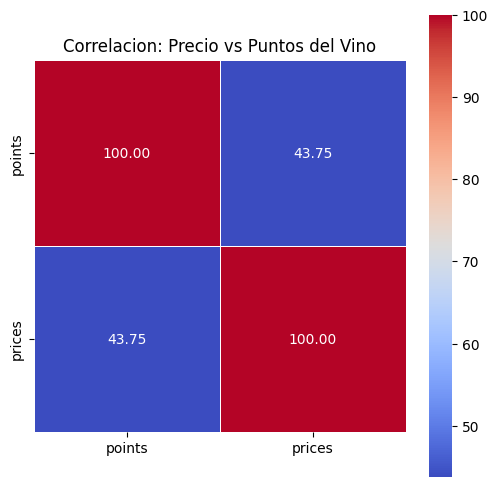

In [9]:
# Correlacion de los datos Precios y Puntaje
correlation = df_stream.stat.corr("Points", "Prices")
print("Pearson correlation:", correlation)

numeric_data = data.select_dtypes(include='number')
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(6, 8))
sns.heatmap(correlation_matrix*100, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True, cbar_kws={"shrink": 0.75})
plt.title('Correlacion: Precio vs Puntos del Vino')
plt.show()

25/07/28 23:40:09 WARN TaskSetManager: Stage 12 contains a task of very large size (49446 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

+-----------+----------+---------+
|country    |avg_points|avg_price|
+-----------+----------+---------+
|Switzerland|88.09     |63.91    |
|England    |91.68     |51.25    |
|US-France  |88.00     |50.00    |
|France     |88.68     |43.17    |
|Hungary    |88.02     |42.83    |
|Germany    |89.19     |40.55    |
|Italy      |88.53     |38.55    |
|Canada     |88.88     |35.24    |
|US         |88.17     |35.01    |
|Luxembourg |87.67     |33.73    |
|Australia  |88.11     |32.59    |
|Israel     |87.75     |31.51    |
|Austria    |89.72     |30.96    |
|Lebanon    |86.67     |27.99    |
|Mexico     |85.02     |27.88    |
|Spain      |86.93     |27.57    |
|Slovenia   |88.09     |26.45    |
|Portugal   |88.25     |26.27    |
|Uruguay    |85.78     |26.16    |
|Turkey     |88.11     |25.05    |
+-----------+----------+---------+
only showing top 20 rows


25/07/28 23:40:11 WARN TaskSetManager: Stage 15 contains a task of very large size (49446 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

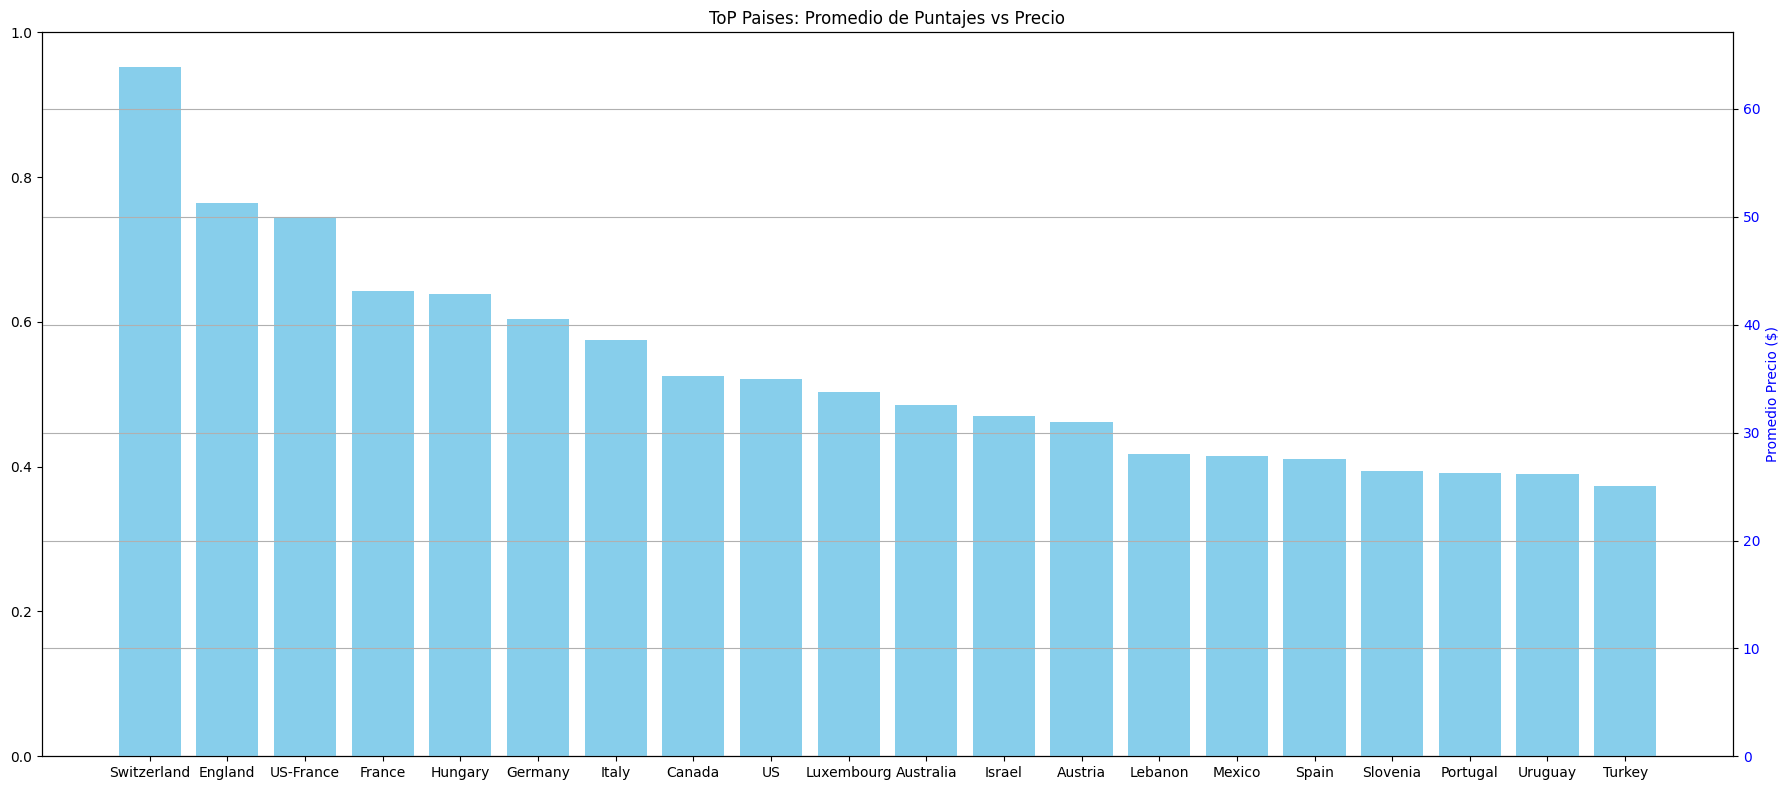

In [10]:

# Step 1: Group and aggregate
agg_df = df_stream.groupBy("country") \
    .agg(
        avg("Points").alias("avg_points"),
        avg("Prices").alias("avg_price")
    ) \
    .orderBy("avg_price", ascending=False)

# Step 2: Format decimals to 2 places (as string, if you want to display)
agg_df_formatted = agg_df \
    .withColumn("avg_points", format_number("avg_points", 2)) \
    .withColumn("avg_price", format_number("avg_price", 2))

# Show formatted result
agg_df_formatted.show(truncate=False)

# Step 3: For plotting — convert to Pandas (use original floats, not formatted strings)
agg_pd = agg_df.toPandas().dropna().head(20)

# Step 4: Plot
fig, ax1 = plt.subplots(figsize=(18, 8))

ax2 = ax1.twinx()
ax2.bar(agg_pd["country"], agg_pd["avg_price"], color='skyblue', label='Avg Points')
ax2.set_ylabel('Promedio Precio ($)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_xticklabels(agg_pd["country"], rotation=90, ha='right')

plt.title("ToP Paises: Promedio de Puntajes vs Precio")
plt.tight_layout()
plt.grid(True)
plt.show()


25/07/28 23:40:34 WARN TaskSetManager: Stage 34 contains a task of very large size (49446 KiB). The maximum recommended task size is 1000 KiB.
25/07/28 23:40:35 WARN TaskSetManager: Stage 37 contains a task of very large size (49446 KiB). The maximum recommended task size is 1000 KiB.


+-----------+----------+---------+
|country    |avg_points|avg_price|
+-----------+----------+---------+
|Switzerland|88.09     |63.91    |
|England    |91.68     |51.25    |
|US-France  |88.00     |50.00    |
|France     |88.68     |43.17    |
|Hungary    |88.02     |42.83    |
|Germany    |89.19     |40.55    |
|Italy      |88.53     |38.55    |
|Canada     |88.88     |35.24    |
|US         |88.17     |35.01    |
|Luxembourg |87.67     |33.73    |
|Australia  |88.11     |32.59    |
|Israel     |87.75     |31.51    |
|Austria    |89.72     |30.96    |
|Lebanon    |86.67     |27.99    |
|Mexico     |85.02     |27.88    |
|Spain      |86.93     |27.57    |
|Slovenia   |88.09     |26.45    |
|Portugal   |88.25     |26.27    |
|Uruguay    |85.78     |26.16    |
|Turkey     |88.11     |25.05    |
+-----------+----------+---------+
only showing top 20 rows


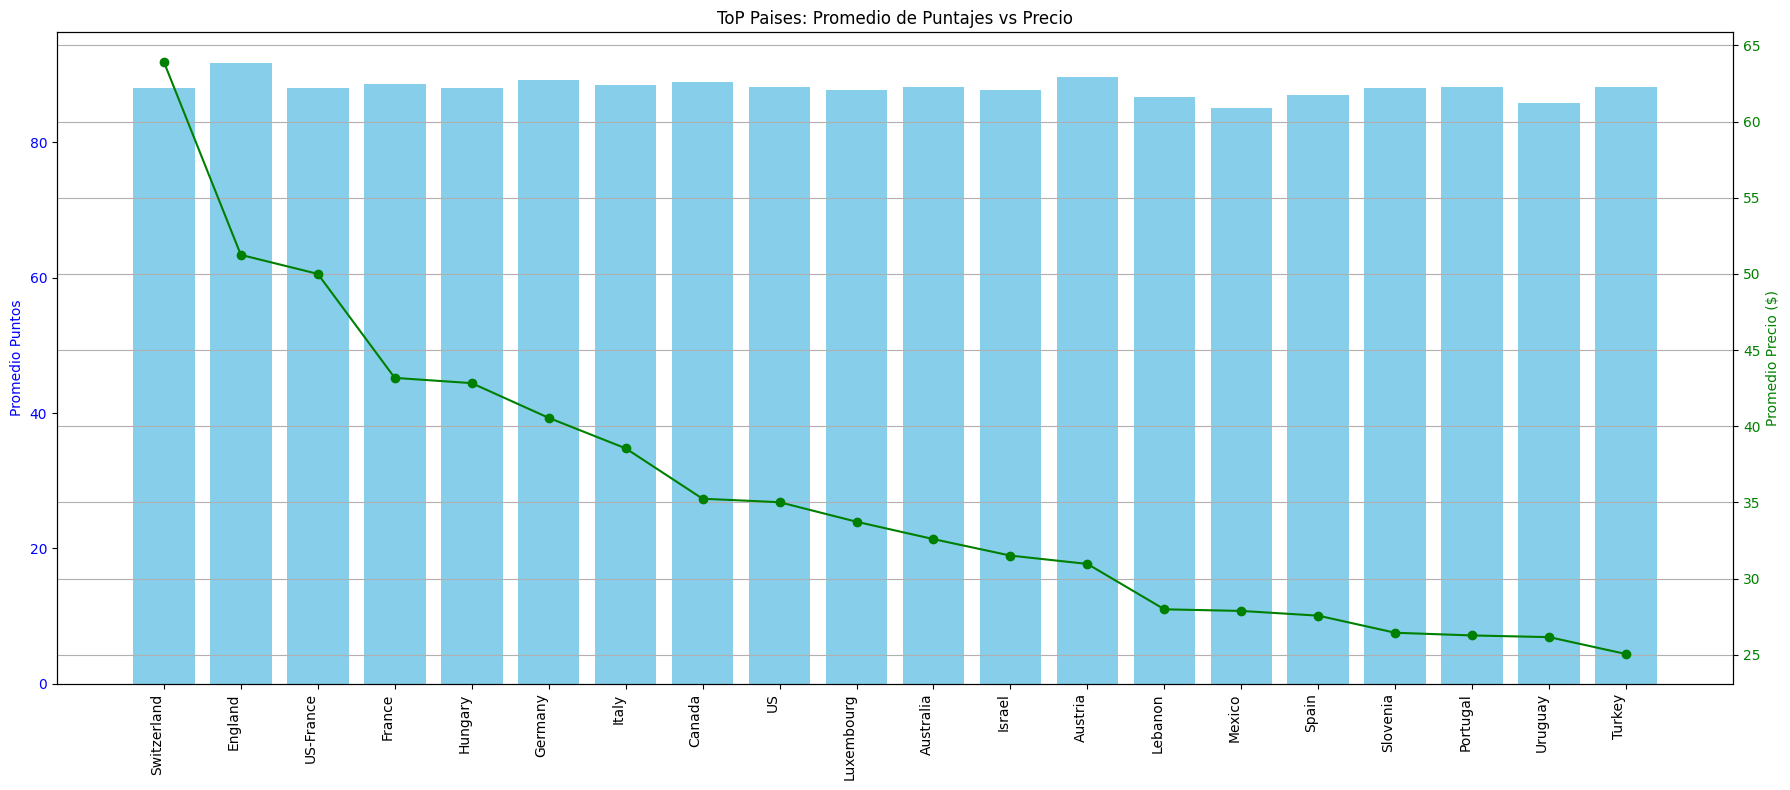

In [12]:

# Step 1: Group and aggregate
agg_df = df_stream.groupBy("country") \
    .agg(
        avg("Points").alias("avg_points"),
        avg("Prices").alias("avg_price")
    ) \
    .orderBy("avg_price", ascending=False)

# Step 2: Format decimals to 2 places (as string, if you want to display)
agg_df_formatted = agg_df \
    .withColumn("avg_points", format_number("avg_points", 2)) \
    .withColumn("avg_price", format_number("avg_price", 2))

# Show formatted result
agg_df_formatted.show(truncate=False)

# Step 3: For plotting — convert to Pandas (use original floats, not formatted strings)
agg_pd = agg_df.toPandas().dropna().head(20)

# Step 4: Plot
fig, ax1 = plt.subplots(figsize=(18, 8))

ax1.bar(agg_pd["country"], agg_pd["avg_points"], color='skyblue', label='Avg Points')
ax1.set_ylabel('Promedio Puntos', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(agg_pd["country"], rotation=90, ha='right')

# Add second axis for avg price
ax2 = ax1.twinx()
ax2.plot(agg_pd["country"], agg_pd["avg_price"], color='green', marker='o', label='Avg Price')
ax2.set_ylabel('Promedio Precio ($)', color='green')
ax2.tick_params(axis='y', labelcolor='green')


plt.title("ToP Paises: Promedio de Puntajes vs Precio")
plt.tight_layout()
plt.grid(True)
plt.show()


### Variedad de Uvas de Vinos

In [ ]:
data.head()

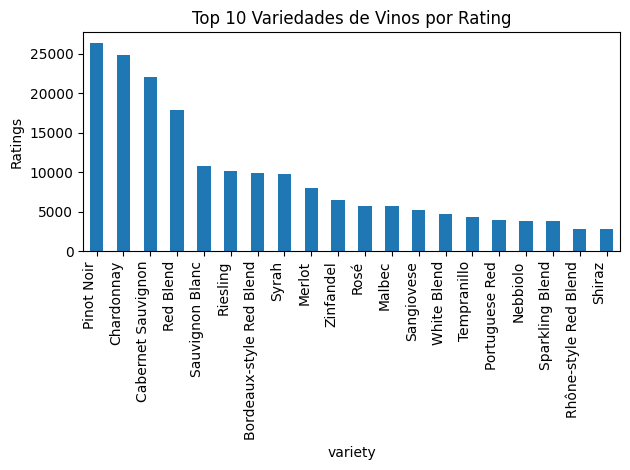

In [13]:
top_ranking_wines= (
    data.groupby('variety')['points'].count()
    .reset_index()
    .sort_values(by='points', ascending=False)
    .head(20)
)
top_ranking_wines.head()
top_ranking_wines.plot.bar(x='variety', y='points', legend=False)
plt.ylabel("Ratings")
plt.title("Top 10 Variedades de Vinos por Rating")
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


#### Frecuencia de Paises con Mayor Presencia en la Reseñas

25/07/28 23:40:50 WARN TaskSetManager: Stage 45 contains a task of very large size (49446 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

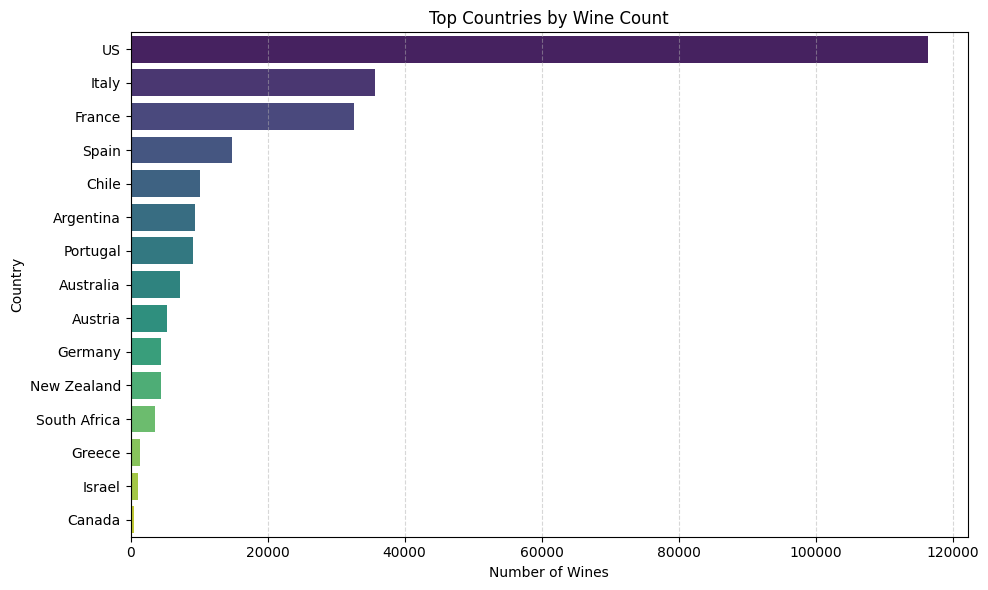

In [14]:


from pyspark.sql.functions import count

df_pandas = df_stream.groupBy("country") \
                      .agg(count("country").alias("country_count")) \
                      .orderBy("country_count", ascending=False)


top_n = 15
features = df_pandas.toPandas().head(top_n)
plt.figure(figsize=(10, 6))
sns.barplot(data=features, x="country_count", y="country", palette="viridis")

plt.title("Top Countries by Wine Count")
plt.xlabel("Number of Wines")
plt.ylabel("Country")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Analitica Descriptiva: Precios

25/07/28 23:41:15 WARN TaskSetManager: Stage 53 contains a task of very large size (49446 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

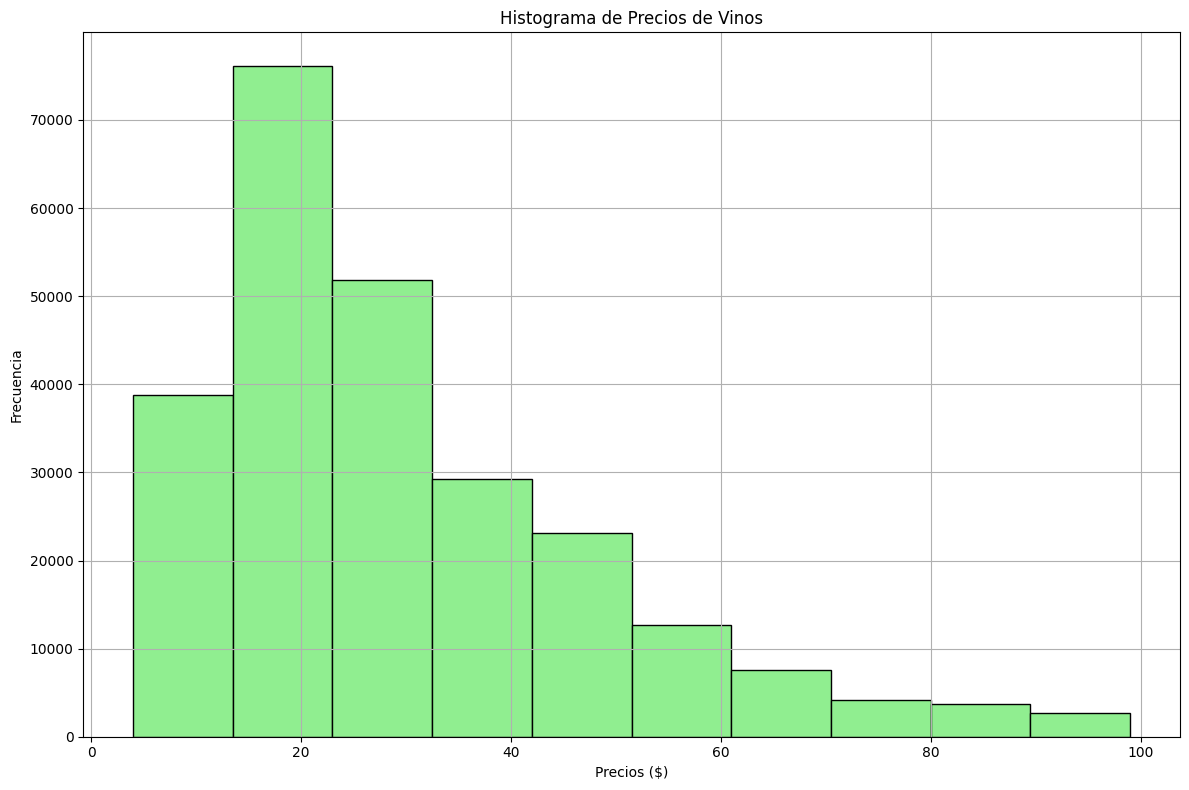

In [16]:
price_pd = df_stream.select("Prices").toPandas()
price_pd = price_pd[price_pd['Prices'] < 100]


plt.figure(figsize=(12, 8))
plt.hist(price_pd["Prices"], bins=10, color="lightgreen", edgecolor="black")
plt.title("Histograma de Precios de Vinos")
plt.xlabel("Precios ($)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

### Analitica Descriptiva: Puntaje

25/07/28 23:41:24 WARN TaskSetManager: Stage 54 contains a task of very large size (49446 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

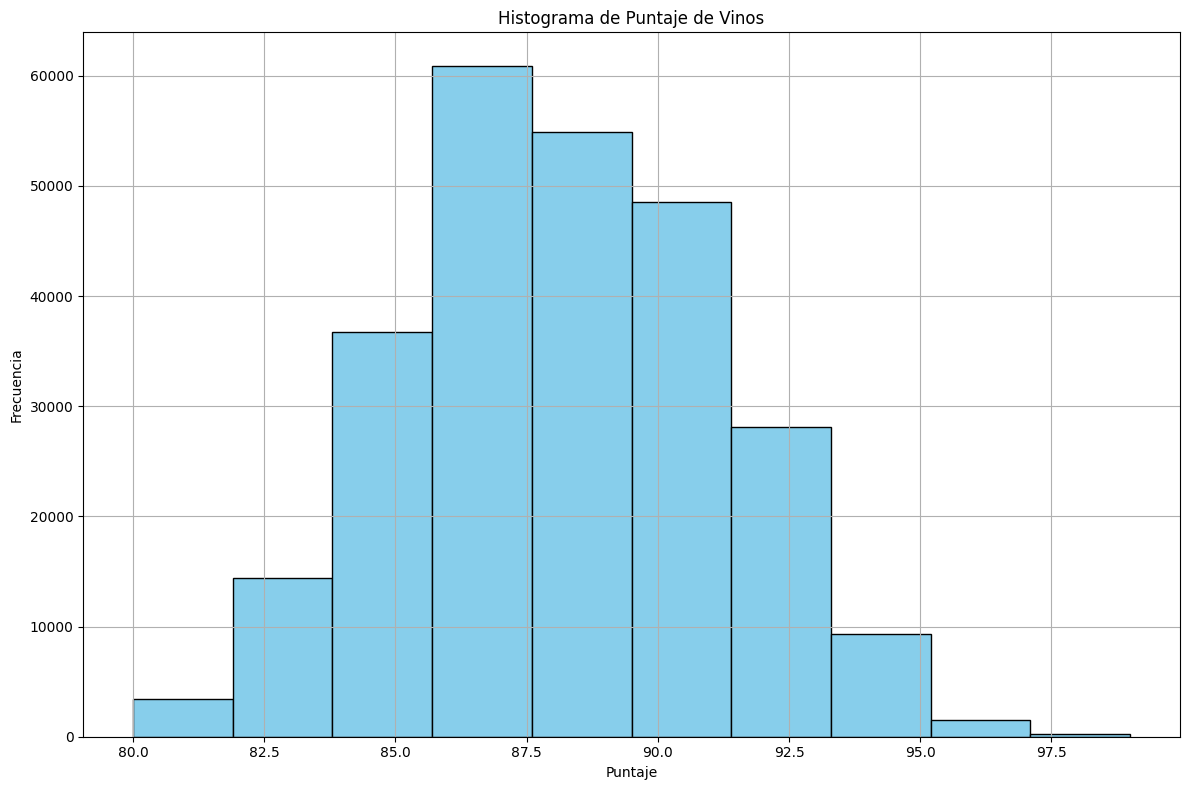

In [17]:
price_pd = df_stream.select("points").toPandas()
price_pd = price_pd[price_pd['points'] < 100]


plt.figure(figsize=(12, 8))
plt.hist(price_pd["points"], bins=10, color="skyblue", edgecolor="black")
plt.title("Histograma de Puntaje de Vinos")
plt.xlabel("Puntaje")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
df_stream.head()

25/07/28 23:45:03 WARN TaskSetManager: Stage 56 contains a task of very large size (49446 KiB). The maximum recommended task size is 1000 KiB.


Row(country='US', description='This wine is beautifully rendered, with pear and melon backed by hints of citrus. The length, persistance, balance and tension are superb, and the mouth-puckering finish will have you reaching for another glass.', designation='Nicholas Estate Dry', points=91.0, prices=22.0, province='Oregon', region_1='Chehalem Mountains', region_2='Willamette Valley', variety='Riesling', winery='Anam Cara')

### Geografia

25/07/28 23:47:43 WARN TaskSetManager: Stage 57 contains a task of very large size (49446 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

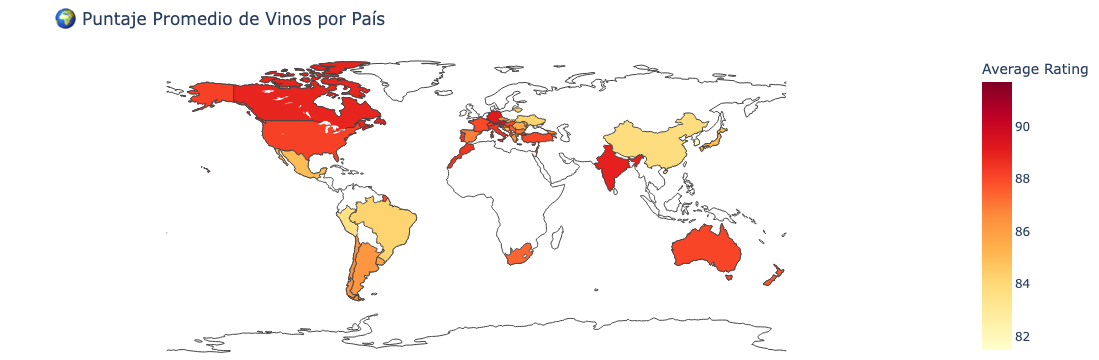

In [26]:
from pyspark.sql.functions import avg, round as pyspark_round
import plotly.express as px

# Eliminar filas con valores nulos en country o points
datax = df_stream.dropna(subset=['country', 'points'])

# Agrupar por país y calcular el promedio de puntuación
country_avg_points = datax.groupBy('country').agg(
    pyspark_round(avg('points'), 1).alias('Points')  # redondeamos a 1 decimal
)

# Convertir a Pandas para usar con Plotly
country_avg_points_pd = country_avg_points.toPandas()

# Crear el mapa coroplético
fig = px.choropleth(
    country_avg_points_pd,
    locations="country",
    locationmode="country names",
    color="Points",
    color_continuous_scale="YlOrRd",
    title="🌍 Puntaje Promedio de Vinos por País",
    labels={"Points": "Average Rating"},
    template="plotly_white"
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True),
    margin={"r":0, "t":50, "l":0, "b":0}
)

fig.show()


### Analitica de Sentimiento

### basado en la Reseña del Vino

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


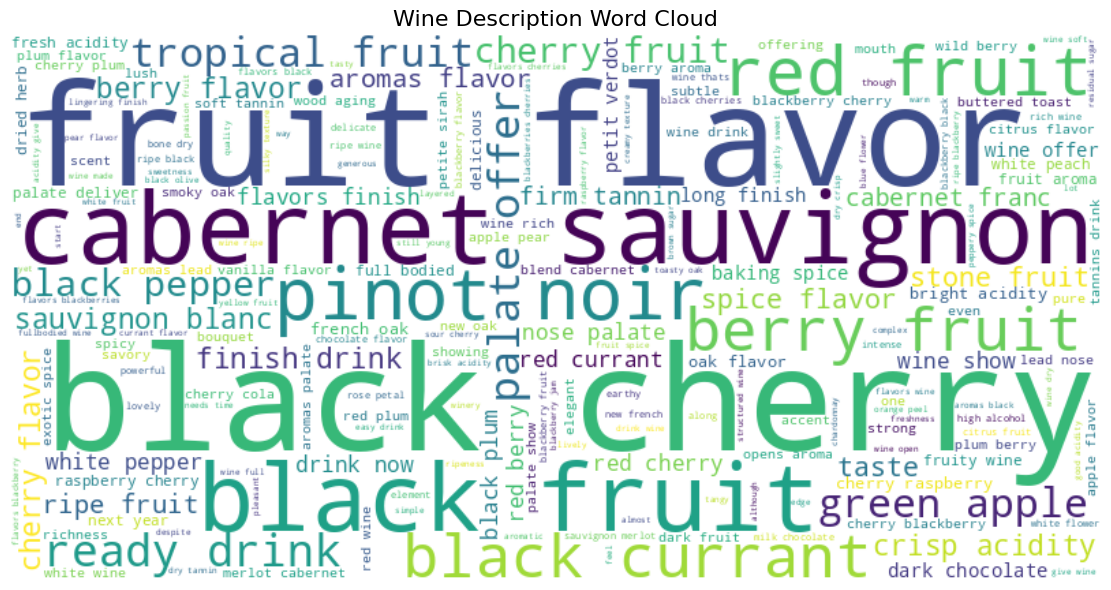

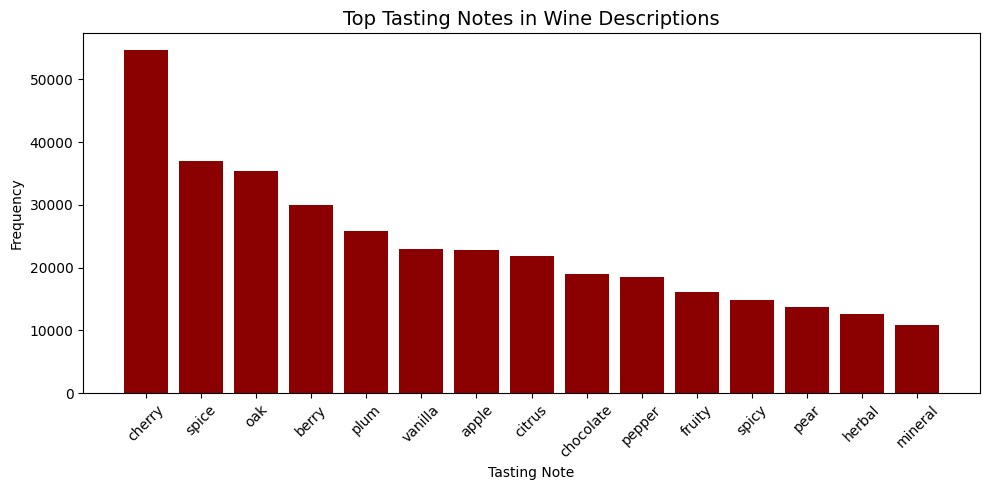

In [25]:
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
import re
import string

# Download NLTK stopwords if not already done
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

data.dropna(subset=['description'])

# Predefined tasting note keywords
tasting_notes = [
    "fruity", "oak", "oaky", "vanilla", "cherry", "berry", "plum", "earthy",
    "leather", "spice", "spicy", "smoky", "herbal", "tobacco", "pepper", "jammy",
    "floral", "buttery", "mineral", "citrus", "apple", "pear", "chocolate", "coffee"
]

# Normalize keywords to lowercase
tasting_notes = [note.lower() for note in tasting_notes]

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply text cleaning
data['tokens'] = data['description'].apply(clean_text)

# Flatten all tokens into one list
all_tokens = [token for sublist in data['tokens'] for token in sublist]

# Create word cloud from all tokens
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_tokens))

# Show word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wine Description Word Cloud', fontsize=16)
plt.tight_layout()

#plt.savefig('word_cloud.png')
plt.show()

# Count tasting note mentions
tasting_note_counts = Counter()

for tokens in data['tokens']:
    for word in tokens:
        if word in tasting_notes:
            tasting_note_counts[word] += 1

# Top tasting notes
top_notes = tasting_note_counts.most_common(15)

# Bar chart of top tasting notes
notes, counts = zip(*top_notes)
plt.figure(figsize=(10, 5))
plt.bar(notes, counts, color='darkred')
plt.title('Top Tasting Notes in Wine Descriptions', fontsize=14)
plt.xlabel('Tasting Note')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()

#plt.savefig('tasting_note.png')
plt.show()

### DATOS

In [18]:
italy_df=data[data['country']=='Israel']
italy_df.to_csv('/home/ubuntu/projectfinal_env/wines_israel.csv')
data.head()

,country,description,designation,points,prices,province,region_1,region_2,variety,winery
0,US,"This wine is beautifully rendered, with pear a...",Nicholas Estate Dry,91.0,22.0,Oregon,Chehalem Mountains,Willamette Valley,Riesling,Anam Cara
1,Chile,"Crisp, spicy, grassy, citrus aromas are all go...",Clava Coastal Reserve,87.0,12.0,Casablanca Valley,None,None,Sauvignon Blanc,Quintay
2,France,This is so fresh and crisp with an attractive ...,Brut,90.0,25.0,Loire Valley,Crémant de Loire,None,Sparkling Blend,Monmousseau
3,US,"Whiffs of sweet baking spice, cedar and tobacc...",None,87.0,26.0,New York,Finger Lakes,Finger Lakes,Cabernet Sauvignon,Ventosa
4,France,Aromas of melon and toasted marshmallow preced...,La Bachole,89.0,120.0,Rhône Valley,Hermitage,None,Rhône-style White Blend,Les Vins de Vienne


### 

### Conclusiones

El enfoque de Big Data para el análisis de reseñas de vinos no solo mejora la eficiencia y profundidad del análisis, sino que abre nuevas posibilidades estratégicas, predictivas y personalizadas. En un mercado competitivo y diverso como el del vino, la capacidad de aprovechar grandes volúmenes de datos de múltiples fuentes es una ventaja competitiva clave.

